# FVC Stability 20200107

This analysis is just asking whether the spots are stable, not whether they are in the right place.

In [196]:
%pylab inline
import os, sys, glob
import desimodel.focalplane
from collections import Counter
import numpy as np
from astropy.table import Table
import fitsio

Populating the interactive namespace from numpy and matplotlib


In [197]:
spotdir='/project/projectdirs/desi/cmx/fvc/stability/20200107'
spotfiles = sorted(glob.glob(spotdir+'/spots-*.csv'))

spots = dict()
for filepath in spotfiles:
    filename = os.path.basename(filepath)
    if filename not in spots:
        spots[filename] = Table.read(filepath)

In [198]:
#- Identify spots found in all exposures
ploc_all = None
for sp in spots.values():
    sp['PLOC'] = 10*sp['LOCATION'] + sp['PINHOLE_ID']
    if ploc_all is None:
        ploc_all = set(sp['PLOC'])
    else:
        ploc_all &= set(sp['PLOC'])

In [199]:
#- Remove multiply identified spots/pinholes from ploc_all
print(len(ploc_all))
for filename, sp in spots.items():
    bad = set()
    for ploc, n in Counter(sp['PLOC']).items():
        if n>1 and ploc in ploc_all:
            ploc_all.remove(ploc)

print(len(ploc_all))

4361
4174


In [200]:
#- Trim spots lists to just those in the ploc_all set
ploc_array = np.array(list(ploc_all))
for filename, sp in list(spots.items()):
    ii = np.in1d(sp['PLOC'], ploc_array)
    spots[filename] = sp[ii]
    spots[filename].sort('PLOC')

## Now put them together

In [201]:
xpix = np.array([np.asarray(sp['XPIX']) for sp in spots.values()])
ypix = np.array([np.asarray(sp['YPIX']) for sp in spots.values()])
xfp = np.array([np.asarray(sp['X_FP']) for sp in spots.values()])
yfp = np.array([np.asarray(sp['Y_FP']) for sp in spots.values()])
xfp_exp = np.array([np.asarray(sp['X_FP_EXP']) for sp in spots.values()])
yfp_exp = np.array([np.asarray(sp['Y_FP_EXP']) for sp in spots.values()])

In [202]:
xpix.shape

(105, 4174)

In [203]:
xpix_mean = xpix.mean(axis=0)
ypix_mean = ypix.mean(axis=0)
xpix_mean.shape, ypix_mean.shape

((4174,), (4174,))

In [204]:
xfp_mean = xfp.mean(axis=0)
yfp_mean = yfp.mean(axis=0)
xfp_mean.shape, yfp_mean.shape

((4174,), (4174,))

In [205]:
xpix_std = np.std(xpix, axis=0)
ypix_std = np.std(ypix, axis=0)

In [206]:
xfp_std = np.std(xfp, axis=0)*1000
yfp_std = np.std(yfp, axis=0)*1000

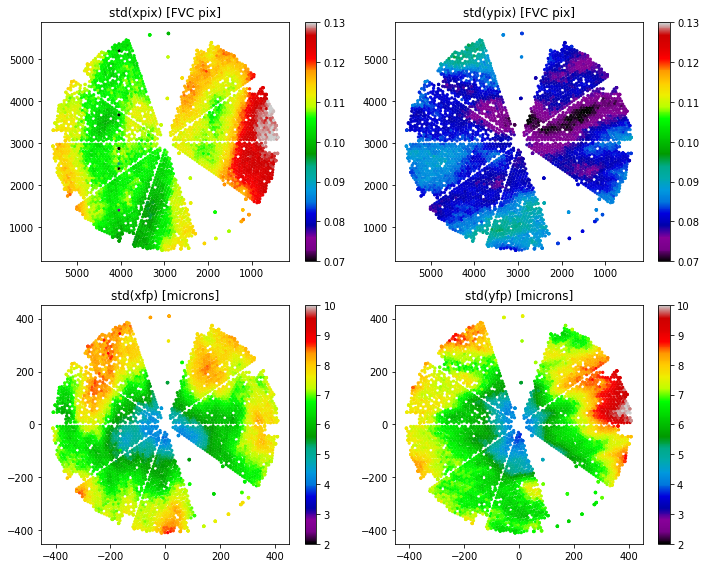

In [207]:
figure(figsize=(10,8))

#- STD in FVC pixel coordinates
opts = dict(vmin=0.07, vmax=0.13, s=5, cmap='nipy_spectral')
subplot(221)
scatter(xpix[0], ypix[0], c=xpix_std, **opts)
a, b = xlim()
xlim(b, a)  #- flip X to match FP orientation
title('std(xpix) [FVC pix]')
colorbar()

subplot(222)
scatter(xpix[0], ypix[0], c=ypix_std, **opts)
a, b = xlim()
xlim(b, a)  #- flip X to match FP orientation
title('std(ypix) [FVC pix]')
colorbar()

#- STD in FP coordinates
opts = dict(vmin=2, vmax=10, s=5, cmap='nipy_spectral')
subplot(223)
scatter(xfp[0], yfp[0], c=xfp_std, **opts)
title('std(xfp) [microns]')
colorbar()

subplot(224)
scatter(xfp[0], yfp[0], c=yfp_std, **opts)
title('std(yfp) [microns]')
colorbar()

tight_layout()

In [208]:
print('microns per FVC pixel (approx):')
1000*(np.max(xfp) - np.min(xfp)) / (np.max(xpix) - np.min(xpix))

microns per FVC pixel (approx):


158.98151181207533

In [209]:
159*0.1

15.9

## Stability vs. time

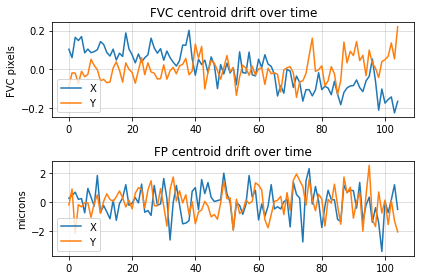

In [210]:
subplot(211)
plot(np.mean((xpix - xpix_mean), axis=1), label='X')
plot(np.mean((ypix - ypix_mean), axis=1), label='Y')
title('FVC centroid drift over time')
ylabel('FVC pixels')
grid()
legend()

subplot(212)
plot(1000*np.mean((xfp - xfp_mean), axis=1), label='X')
plot(1000*np.mean((yfp - yfp_mean), axis=1), label='Y')
title('FP centroid drift over time')
ylabel('microns')
grid()
legend()

tight_layout()

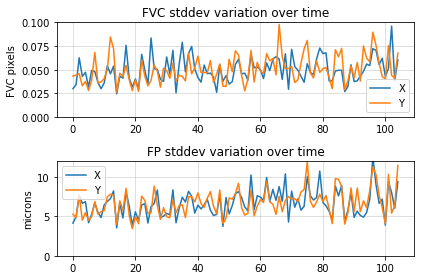

In [211]:
subplot(211)
plot(np.std((xpix - xpix_mean), axis=1), label='X')
plot(np.std((ypix - ypix_mean), axis=1), label='Y')
title('FVC stddev variation over time')
ylim(0, 0.1)
ylabel('FVC pixels')
grid()
legend()

subplot(212)
plot(1000*np.std((xfp - xfp_mean), axis=1), label='X')
plot(1000*np.std((yfp - yfp_mean), axis=1), label='Y')
title('FP stddev variation over time')
ylim(0, 12)
ylabel('microns')
grid()
legend()

tight_layout()

In [212]:
## Redo std plots while removing overall drift in FVC x,y

In [213]:
dxpix = xpix - xpix_mean
dypix = ypix - ypix_mean

In [214]:
dxfp = xfp - xfp_mean
dyfp = yfp - yfp_mean

In [215]:
dxpix.shape

(105, 4174)

In [216]:
dxpix.mean(axis=1).shape

(105,)

In [217]:
#- Note difference from before: subtracting per-exposure mean
xpix_std = np.std(dxpix.T - dxpix.mean(axis=1), axis=1)
ypix_std = np.std(dypix.T - dypix.mean(axis=1), axis=1)

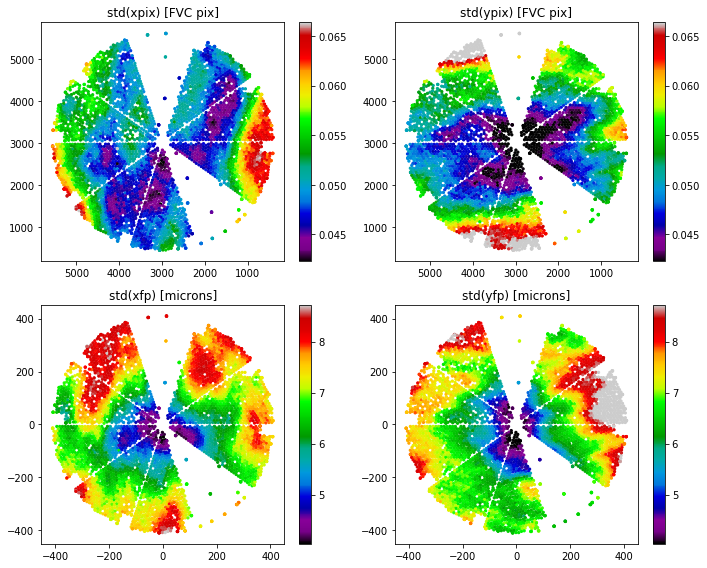

In [218]:
figure(figsize=(10,8))

#- STD in FVC pixel coordinates
vmin, vmax = np.percentile(xpix_std, (0.1, 99.9))
opts = dict(vmin=vmin, vmax=vmax, s=5, cmap='nipy_spectral')
subplot(221)
scatter(xpix[0], ypix[0], c=xpix_std, **opts)
a, b = xlim()
xlim(b, a)  #- flip X to match FP orientation
title('std(xpix) [FVC pix]')
colorbar()

subplot(222)
scatter(xpix[0], ypix[0], c=ypix_std, **opts)
a, b = xlim()
xlim(b, a)  #- flip X to match FP orientation
title('std(ypix) [FVC pix]')
colorbar()

#- STD in FP coordinates
vmin, vmax = np.percentile(xfp_std, (0.1, 99.9))
opts = dict(vmin=vmin, vmax=vmax, s=5, cmap='nipy_spectral')
subplot(223)
scatter(xfp[0], yfp[0], c=xfp_std, **opts)
title('std(xfp) [microns]')
colorbar()

subplot(224)
scatter(xfp[0], yfp[0], c=yfp_std, **opts)
title('std(yfp) [microns]')
colorbar()

tight_layout()

## Quiver plots of the first few exposures

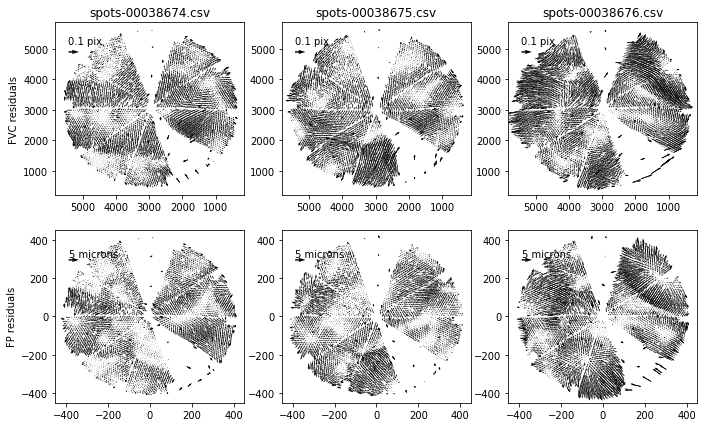

In [239]:
def plot_dxdy(x, y, dx, dy, scale=2000, flipx=False, scalebar=None, scaletext=None):
    quiver(x, y, dx-np.mean(dx), dy-np.mean(dy), scale=1/scale, scale_units='xy')

    b = np.percentile(y, 95)
    if flipx:
        a = np.percentile(x, 99)
    else:
        a = np.percentile(x, 1)
    if scalebar:
        quiver([a,], [b,], [scalebar,], [0,])
    if scaletext:
        text(a, b*1.05, scaletext)

    if flipx:
        a, b = xlim()
        xlim(b, a)

filenames = list(spots.keys())
        
figure(figsize=(11.5,7))

nexp = 3
for i in range(nexp):
    subplot(2,nexp,i+1)
    plot_dxdy(xpix[i], ypix[i], dxpix[i], dypix[i], flipx=True, scalebar=0.1, scaletext='0.1 pix')
    title(filenames[i])
    if i == 0:
        ylabel('FVC residuals')

    subplot(2,nexp,nexp+i+1)
    plot_dxdy(xfp[i], yfp[i], dxfp[i], dyfp[i], scalebar=5, scaletext='5 microns')
    if i == 0:
        ylabel('FP residuals')


## Quiver plots spread out over the full range of the test

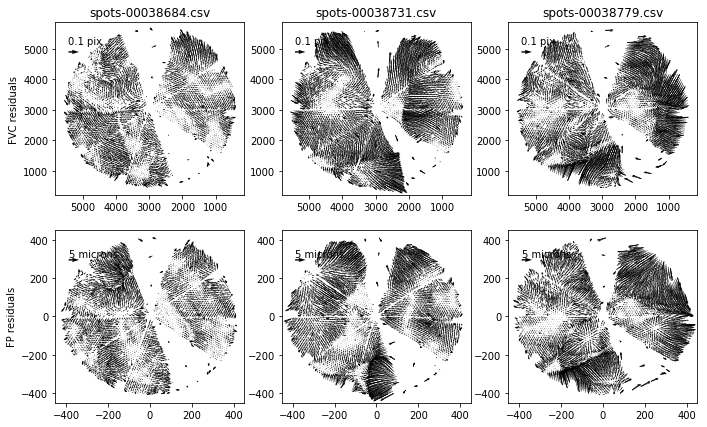

In [244]:
figure(figsize=(11.5,7))

nexp = 3
jj = np.linspace(10, len(spots)-1, nexp).astype(int)
# jj = np.arange(3)+6
for i in range(nexp):
    j = jj[i]
    subplot(2,nexp,i+1)
    plot_dxdy(xpix[j], ypix[j], dxpix[j], dypix[j], flipx=True, scalebar=0.1, scaletext='0.1 pix')
    title(filenames[j])
    if i == 0:
        ylabel('FVC residuals')

    subplot(2,nexp,nexp+i+1)
    plot_dxdy(xfp[j], yfp[j], dxfp[j], dyfp[j], scalebar=5, scaletext='5 microns')
    if i == 0:
        ylabel('FP residuals')



## RMS of per-exposure offset

In [245]:
dxpix.shape

(105, 4174)

In [250]:
dpixrms = list()
dfprms = list()
for i in range(dxpix.shape[0]):
    mx = np.mean(dxpix[i])
    my = np.mean(dypix[i])
    drpix = np.sqrt((dxpix[i]-mx)**2 + (dypix[i]-my)**2)
    dpixrms.append(np.sqrt(np.mean(drpix**2)))
    
    mx = np.mean(dxfp[i])
    my = np.mean(dyfp[i])
    drfp = np.sqrt((dxfp[i]-mx)**2 + (dyfp[i]-my)**2)
    dfprms.append(1000*np.sqrt(np.mean(drfp**2)))

Text(0.5,0,'FP RMS [microns]')

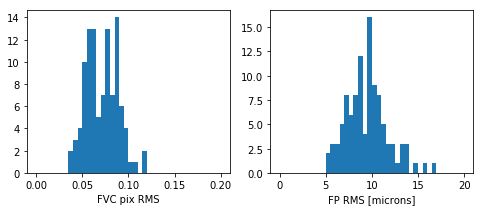

In [254]:
figure(figsize=(8,3))
subplot(121)
hist(dpixrms, 40, (0, 0.2))
xlabel('FVC pix RMS')

subplot(122)
hist(dfprms, 40, (0, 20))
xlabel('FP RMS [microns]')


## Platemaker numbers

In [221]:
datadir = '/project/projectdirs/desi/spectro/data'
night = 20200107
expid = 38674
coordfile = '{datadir}/{night}/{expid:08d}/coordinates-{expid:08d}.fits'.format(
    datadir=datadir, night=night, expid=expid)

In [222]:
pm = Table.read(coordfile)

In [223]:
pm.colnames

['PETAL_LOC',
 'DEVICE_LOC',
 'CONVERGED',
 'EXP_Q_0',
 'EXP_S_0',
 'FLAGS_EXP_0',
 'FLAGS_FVC_0',
 'FVC_ID',
 'FVC_X_0',
 'FVC_Y_0',
 'CNT_X_0',
 'CNT_Y_0',
 'FLAGS_CNT_0',
 'CNT_MAG_0',
 'CNT_ERR_0',
 'FPA_Q_0',
 'FPA_S_0',
 'FLAGS_FPA_0',
 'FPA_DQ_0',
 'FPA_DS_0',
 'DEVICE_ID']

In [224]:
sp.colnames

['XPIX',
 'YPIX',
 'XERR',
 'YERR',
 'COUNTS',
 'LOCATION',
 'PINHOLE_ID',
 'PETAL_LOC',
 'DEVICE_LOC',
 'X_FP',
 'Y_FP',
 'X_FP_METRO',
 'Y_FP_METRO',
 'Z_FP_METRO',
 'X_FP_EXP',
 'Y_FP_EXP',
 'EXP_Q_0',
 'EXP_S_0',
 'PLOC']

In [225]:
#- Keep just the devices that the desimeter analysis used
for sp in spots.values():
    break

pm['LOCATION'] = 1000*pm['PETAL_LOC'] + pm['DEVICE_LOC']
keep = np.in1d(pm['LOCATION'], sp['LOCATION'])

#- Further trim to ok data
keep &= ~np.isnan(pm['FPA_Q_0'] + pm['FPA_S_0'] + pm['EXP_Q_0'] + pm['EXP_S_0'])
pm = pm[keep]

In [226]:
xfp_pm, yfp_pm = desimodel.focalplane.qs2xy(pm['FPA_Q_0'], pm['FPA_S_0'])
xfp_pm_exp, yfp_pm_exp = desimodel.focalplane.qs2xy(pm['EXP_Q_0'], pm['EXP_S_0'])
dxfp_pm = xfp_pm - xfp_pm_exp
dyfp_pm = yfp_pm - yfp_pm_exp

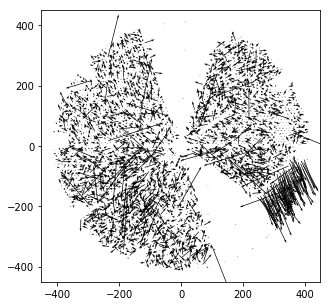

In [227]:
figure(figsize=(5,5))
ii = (np.abs(dxfp_pm)<1) & (np.abs(dyfp_pm)<1)
plot_dxdy(xfp_pm[ii], yfp_pm[ii], dxfp_pm[ii], dyfp_pm[ii], scale=200)

In [228]:
np.max(np.abs(dyfp_pm))

4.440811494472712

## To do

Compare EXP_Q_0, EXP_S_0 -> X_FP_EXP, Y_FP_EXP; vs. X_FVC, Y_FVX -> X_FP, Y_FP

In [229]:
len(spots)

105